# BÀI THỰC HÀNH PHẦN SOFT MARGIN SUPPORT VECTOR MACHINE

### Ví dụ 1: Chúng ta vẫn bắt đầu với một ví dụ trên dữ liệu nhân tạo, tương tự như các phương pháp trước. Trước hết ta tạo một bộ dữ liệu có 200 mẫu (N=200) phân đều vào 02 lớp – mỗi lớp 100 phần tử. Mỗi mẫu có 2 chiều (d=2). Tiếp theo chúng ta xây dựng các phương thức cần thiết cho phương pháp Soft Margin Vector Machine và tiến hành thực hiện phân lớp trên bộ dữ liệu nói trên.

### Cách 1.

In [83]:
# generate data
# list of points
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X0[-1, :] = [4.5, 1.2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

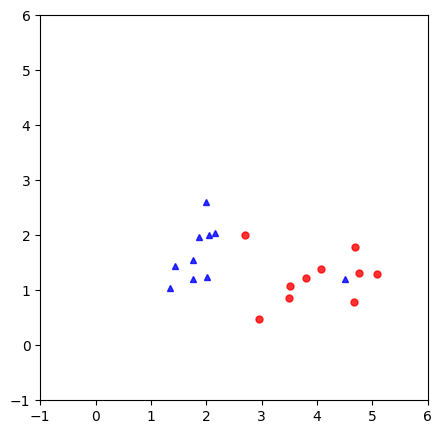

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

In [85]:
#!pip install cvxopt
from cvxopt import matrix, solvers
C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
# K ~ P in lib cvxopt.qp
K = matrix(V.T.dot(V))

q = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, q, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.23267347e-07 4.85674336e+01 9.99999981e+01 1.57381885e-07
  1.40373846e-07 5.28974755e-08 4.87560151e-07 1.81225362e-07
  9.27217960e-08 1.00000000e+02 9.01112774e-08 5.15612516e-08
  3.58687179e-07 3.18585409e-07 7.07041178e-07 9.76857085e+01
  6.09091270e-08 5.08817211e+01 1.76779299e-06 9.99999999e+01]]


### Cách 2. Xây dựng phương pháp giải bài toán tối ưu không ràng buộc:

In [86]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data
Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C
def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
        .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias
def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g
eps = 1e-6

In [87]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w
w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 24.312820


/var/folders/2p/p4mj443j4j56m0lgzq98w6qc0000gp/T/ipykernel_57498/584212659.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter %d' %it + ' cost: %f' %cost(w))


iter 10001 cost: 4.963527
iter 20001 cost: 4.969327
iter 30001 cost: 4.961336
iter 40001 cost: 4.961370
iter 50001 cost: 4.961404
iter 60001 cost: 4.961438
iter 70001 cost: 4.969322
iter 80001 cost: 4.969296
iter 90001 cost: 4.969269
[[-1.07049082  0.99874462]] [1.68169917]


### Cách 3. Sử dụng thư viện:

In [88]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-1.06600888  1.01354038]]
b =  [1.66151836]


So sánh bộ trọng số tối ưu của ba phương pháp Soft Margin SVM
Trong bài thực hành, cùng một bộ dữ liệu và cùng tham số 𝐶 = 100
C=100 được sử dụng để huấn luyện mô hình Soft Margin Support Vector Machine bằng ba cách khác nhau:
Cách 1: Giải bài toán đối ngẫu bằng phương pháp Lagrange với thư viện CVXOPT
Cách 2: Giải bài toán tối ưu không ràng buộc bằng Gradient Descent với hàm mất mát hinge
Cách 3: Sử dụng thư viện sklearn (SVC kernel tuyến tính)

### BÀI THỰC HÀNH 1

Tạo dữ liệu

In [89]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(21)

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10

X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)

X1[-1, :] = [2.7, 2]
X0[-1, :] = [4.5, 1.2]

X = np.vstack((X0, X1))                      # (2N, 2)
y = np.hstack((np.ones(N), -np.ones(N)))     # (2N,)


Huấn luyện & dự đoán (ví dụ với C = 100)

In [90]:
clf = SVC(kernel='linear', C=100)
clf.fit(X, y)

y_pred = clf.predict(X)

acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print("w =", clf.coef_)
print("b =", clf.intercept_)
print("Accuracy =", acc)
print("Confusion Matrix:\n", cm)


w = [[-1.06600888  1.01354038]]
b = [1.66151836]
Accuracy = 0.9
Confusion Matrix:
 [[9 1]
 [1 9]]


Thay đổi tham số C và so sánh kết quả

In [91]:
C_values = [1000, 200, 10, 0.5]

for C in C_values:
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print(f"\n C = {C} ")
    print("w =", clf.coef_)
    print("b =", clf.intercept_)
    print("Accuracy =", accuracy_score(y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))



 C = 1000 
w = [[-1.06653242  1.01479775]]
b = [1.66176304]
Accuracy = 0.9
Confusion Matrix:
 [[9 1]
 [1 9]]

 C = 200 
w = [[-1.06696752  1.01310859]]
b = [1.66454149]
Accuracy = 0.9
Confusion Matrix:
 [[9 1]
 [1 9]]

 C = 10 
w = [[-1.10103939  0.51083347]]
b = [2.3258627]
Accuracy = 0.9
Confusion Matrix:
 [[9 1]
 [1 9]]

 C = 0.5 
w = [[-1.01747184  0.54544914]]
b = [2.07460967]
Accuracy = 0.9
Confusion Matrix:
 [[9 1]
 [1 9]]


### BÀI THỰC HÀNH 2 – PHÂN LOẠI UNG THƯ VÚ BẰNG SVM

In [92]:
import numpy as np
from sklearn import datasets

cancer_data = datasets.load_breast_cancer()

print("Kích thước dữ liệu:", cancer_data.data.shape)
print("Số thuộc tính:", len(cancer_data.feature_names))
print("Nhãn lớp:", cancer_data.target_names)


Kích thước dữ liệu: (569, 30)
Số thuộc tính: 30
Nhãn lớp: ['malignant' 'benign']


In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cancer_data.data,
    cancer_data.target,
    test_size=0.3,
    random_state=109
)


Chuẩn hoá dữ liệu

In [94]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Áp dụng SVM (Soft Margin) – Kernel Linear

In [95]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy =", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy = 0.9883040935672515
Confusion Matrix:
 [[ 61   2]
 [  0 108]]


Thử nhiều Kernel khác nhau

In [96]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    clf = SVC(kernel=k, C=1, gamma='scale')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"\nKernel = {k}")
    print("Accuracy =", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Kernel = linear
Accuracy = 0.9883040935672515
Confusion Matrix:
 [[ 61   2]
 [  0 108]]

Kernel = poly
Accuracy = 0.9005847953216374
Confusion Matrix:
 [[ 46  17]
 [  0 108]]

Kernel = rbf
Accuracy = 0.9824561403508771
Confusion Matrix:
 [[ 60   3]
 [  0 108]]

Kernel = sigmoid
Accuracy = 0.9824561403508771
Confusion Matrix:
 [[ 60   3]
 [  0 108]]


Ảnh hưởng của tham số C

In [97]:
C_values = [1000, 100, 10, 1, 0.1]

for C in C_values:
    clf = SVC(kernel='rbf', C=C, gamma='scale')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"\nC = {C}")
    print("Accuracy =", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



C = 1000
Accuracy = 0.9824561403508771
Confusion Matrix:
 [[ 61   2]
 [  1 107]]

C = 100
Accuracy = 0.9824561403508771
Confusion Matrix:
 [[ 61   2]
 [  1 107]]

C = 10
Accuracy = 0.9883040935672515
Confusion Matrix:
 [[ 61   2]
 [  0 108]]

C = 1
Accuracy = 0.9824561403508771
Confusion Matrix:
 [[ 60   3]
 [  0 108]]

C = 0.1
Accuracy = 0.9415204678362573
Confusion Matrix:
 [[ 57   6]
 [  4 104]]


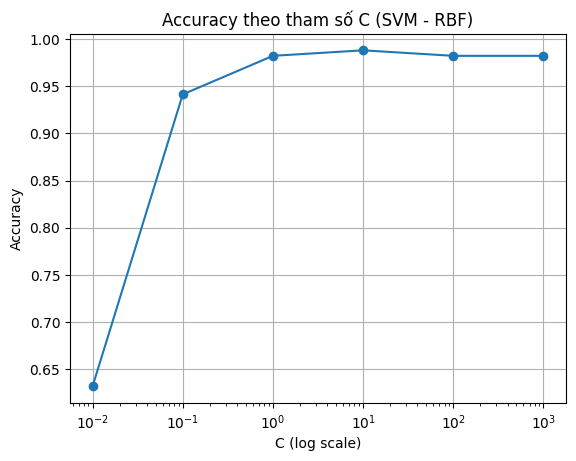

In [98]:

C_values = [0.01, 0.1, 1, 10, 100, 1000]
accuracies = []
for C in C_values:
    clf = SVC(kernel='rbf', C=C, gamma='scale')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Vẽ biểu đồ
plt.figure()
plt.plot(C_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy theo tham số C (SVM - RBF)')
plt.grid(True)
plt.show()

### VÍ DỤ 2 – PHÂN LOẠI DỮ LIỆU SONAR BẰNG SOFT MARGIN SVM

In [99]:
import numpy as np
import pandas as pd

# Đọc dữ liệu
data = pd.read_csv('/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab12/sonar.all-data (2).csv', header=None)

# Tách X và y
X = data.iloc[:, :-1].values    
y = data.iloc[:, -1].values     

# Chuyển nhãn: M -> 1, R -> -1
y = np.where(y == 'M', 1, -1)

print("Kích thước X:", X.shape)
print("Kích thước y:", y.shape)


Kích thước X: (208, 60)
Kích thước y: (208,)


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Áp dụng Soft Margin SVM (kernel tuyến tính)

In [101]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("w =", clf.coef_)
print("b =", clf.intercept_)
print("Accuracy =", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


w = [[ 0.56489885 -0.11986803 -0.50696203  0.86199275  0.03423143  0.11034837
  -0.94859708 -0.37936594  0.77350758 -0.2304362   0.74178158  0.94396807
  -0.29962041 -0.40804185 -0.07602028 -0.31082862 -0.31766801  0.40402028
   0.13649864  0.01583744 -0.22963478  0.36176888  0.27712101  0.41896525
   0.40942333 -0.25038962  0.02421113  0.12085145  0.24193566  1.17748093
  -1.85104194  0.21982482  0.84390792 -0.41406485  0.20897022 -1.13103456
  -0.77646515  0.83028888  0.4129029  -0.64619817 -0.30533926 -0.49260914
   0.8946871  -0.40795559  0.69556715  0.41780015  0.23098148  0.77664397
   0.95148636 -0.83244617 -0.02204508  0.33213204  0.040081    0.84417543
  -0.24042864 -0.29286609 -0.13256464  0.38249607  0.16921733  0.19615452]]
b = [0.56139149]
Accuracy = 0.7619047619047619
Confusion Matrix:
 [[21  7]
 [ 8 27]]


kernel RBF

In [102]:
clf_rbf = SVC(kernel='rbf', C=10, gamma='scale')
clf_rbf.fit(X_train, y_train)

y_pred_rbf = clf_rbf.predict(X_test)

print("Accuracy (RBF) =", accuracy_score(y_test, y_pred_rbf))
print("Confusion Matrix (RBF):\n",
      confusion_matrix(y_test, y_pred_rbf))


Accuracy (RBF) = 0.9523809523809523
Confusion Matrix (RBF):
 [[27  1]
 [ 2 33]]


Thử nhiều giá trị C

In [103]:
C_values = [0.1, 1, 10, 100]

for C in C_values:
    clf = SVC(kernel='rbf', C=C, gamma='scale')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"\nC = {C}")
    print("Accuracy =", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



C = 0.1
Accuracy = 0.5555555555555556
Confusion Matrix:
 [[ 0 28]
 [ 0 35]]

C = 1
Accuracy = 0.9047619047619048
Confusion Matrix:
 [[25  3]
 [ 3 32]]

C = 10
Accuracy = 0.9523809523809523
Confusion Matrix:
 [[27  1]
 [ 2 33]]

C = 100
Accuracy = 0.9523809523809523
Confusion Matrix:
 [[27  1]
 [ 2 33]]


VÍ DỤ 3 – PHÂN LOẠI THƯ RÁC BẰNG SOFT MARGIN SVM

In [104]:
import numpy as np
import pandas as pd


data = pd.read_csv('/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab13/spambase.data', header=None)

# Tách X và y
X = data.iloc[:, :-1].values     
y = data.iloc[:, -1].values    

# Đổi nhãn: 1 -> 1, 0 -> -1
y = np.where(y == 1, 1, -1)

print("Kích thước X:", X.shape)
print("Kích thước y:", y.shape)


Kích thước X: (4601, 57)
Kích thước y: (4601,)


In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)


Chuẩn hoá dữ liệu

In [106]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Huấn luyện Soft Margin SVM

In [107]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

# Dự đoán trên train & test
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print("TRAIN Accuracy =", accuracy_score(y_train, y_train_pred))
print("TRAIN Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

print("\nTEST Accuracy =", accuracy_score(y_test, y_test_pred))
print("TEST Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


TRAIN Accuracy = 0.9329192546583851
TRAIN Confusion Matrix:
 [[1893   91]
 [ 125 1111]]

TEST Accuracy = 0.9268645908761767
TEST Confusion Matrix:
 [[766  38]
 [ 63 514]]


kernel RBF

In [108]:
clf_rbf = SVC(kernel='rbf', C=10, gamma='scale')
clf_rbf.fit(X_train, y_train)

y_train_pred = clf_rbf.predict(X_train)
y_test_pred = clf_rbf.predict(X_test)

print("TRAIN Accuracy (RBF) =", accuracy_score(y_train, y_train_pred))
print("TRAIN Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

print("\nTEST Accuracy (RBF) =", accuracy_score(y_test, y_test_pred))
print("TEST Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


TRAIN Accuracy (RBF) = 0.9645962732919254
TRAIN Confusion Matrix:
 [[1951   33]
 [  81 1155]]

TEST Accuracy (RBF) = 0.939898624185373
TEST Confusion Matrix:
 [[774  30]
 [ 53 524]]


Thử nhiều giá trị C

In [109]:
C_values = [0.1, 1, 10, 100]

for C in C_values:
    clf = SVC(kernel='rbf', C=C, gamma='scale')
    clf.fit(X_train, y_train)
    
    y_test_pred = clf.predict(X_test)
    
    print(f"\nC = {C}")
    print("Accuracy =", accuracy_score(y_test, y_test_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



C = 0.1
Accuracy = 0.9015206372194062
Confusion Matrix:
 [[779  25]
 [111 466]]

C = 1
Accuracy = 0.9348298334540188
Confusion Matrix:
 [[776  28]
 [ 62 515]]

C = 10
Accuracy = 0.939898624185373
Confusion Matrix:
 [[774  30]
 [ 53 524]]

C = 100
Accuracy = 0.9203475742215785
Confusion Matrix:
 [[764  40]
 [ 70 507]]


### Ví dụ 5

In [110]:
import pandas as pd
import numpy as np

# Đọc dữ liệu
data = pd.read_csv(
    "/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab13/Admission_Predict.csv"
)

# Xóa khoảng trắng thừa ở tên cột
data.columns = data.columns.str.strip()

print(data.columns)

# Xóa cột không cần thiết
data = data.drop(columns=['Serial No.'])

# Tách X và y
X = data.drop(columns=['Chance of Admit']).values
y = data['Chance of Admit'].values

# Chuyển nhãn về bài toán phân loại
y = np.where(y >= 0.5, 1, -1)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Số mẫu đậu:", np.sum(y == 1))
print("Số mẫu rớt:", np.sum(y == -1))


Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')
X shape: (400, 7)
y shape: (400,)
Số mẫu đậu: 367
Số mẫu rớt: 33


In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


Chuẩn hóa dữ liệu

In [112]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


SVM Soft Margin

In [113]:
from sklearn.svm import SVC

C = 10   # có thể thay: 0.5, 10, 200, 1000
svm = SVC(kernel='linear', C=C)

svm.fit(X_train, y_train)

# Dự đoán
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Đánh giá
print("===== SVM SOFT MARGIN =====")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("w =", svm.coef_)
print("b =", svm.intercept_)


===== SVM SOFT MARGIN =====
Train Accuracy: 0.9607142857142857
Test Accuracy : 0.9333333333333333
Confusion Matrix (Test):
[[  7   7]
 [  1 105]]
w = [[-0.01458254  0.98627169 -0.99516199 -0.01898462  0.43459691  1.25583998
  -0.07002636]]
b = [3.09681475]


Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

# Dự đoán
y_train_pred_lr = log_reg.predict(X_train)
y_test_pred_lr = log_reg.predict(X_test)

print("\n LOGISTIC REGRESSION ")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_lr))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred_lr))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_lr))

print("w =", log_reg.coef_)
print("b =", log_reg.intercept_)



 LOGISTIC REGRESSION 
Train Accuracy: 0.95
Test Accuracy : 0.925
Confusion Matrix (Test):
[[  5   9]
 [  0 106]]
w = [[ 0.55903957  1.01643195 -0.74546771 -0.30885745  0.89579316  1.45922836
  -0.1364339 ]]
b = [4.80933592]


Vẽ Accuracy theo C

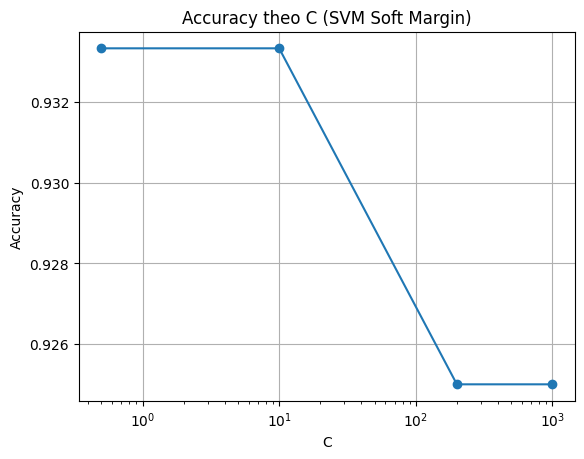

In [115]:
import matplotlib.pyplot as plt

C_list = [0.5, 10, 200, 1000]
acc_test = []

for C in C_list:
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc_test.append(accuracy_score(y_test, y_pred))

plt.plot(C_list, acc_test, marker='o')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy theo C (SVM Soft Margin)")
plt.grid(True)
plt.show()
